# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 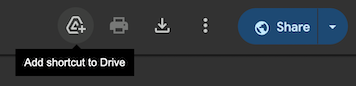

Скачаем данные для обучения и тестирования:

In [6]:
# Подключение диска к работе.
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
dataset = pd.read_csv("/content/drive/MyDrive/salary_dataset.csv")
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Выведем число объектов в датасете

In [ ]:
dataset.shape[0]

200000

Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [ ]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [8]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [ ]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for vac in range(dataset.shape[0]):
    text = dataset.iloc[vac]["FullDescription"]
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [ ]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [ ]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [ ]:
dataset.dtypes

FullDescription     object
SalaryNormalized     int64
dtype: object

Так как target - вещественный признак, то нужно применять тензор поддерживающий числа с плавающей точкой. Будем использовать FloatTensor.

In [ ]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.FloatTensor(np.array(target))

    # дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 141, 18, 25000, 25000, 3605, 25000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4674, 393, 871, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1517, 658, 0, 24450, 25000, 15730, 13311, 87, ...
Таргет: 72098.0 


При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [ ]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.0897, 0.2894, 0.3077, ...


Сформируйте даталоадеры для обучения и валидации.

In [ ]:
batch_sz = 256  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=batch_sz, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=batch_sz, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

Цель этой задаче не классификация объектов, а предсказание значения таргета, поэтому каждому объекту будем сопоставлять ровно одно значение.

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """Модель для регрессии на основе LSTM"""

    def __init__(
        self, num_tokens, emb_size=512, rnn_num_units=64, output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()

        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(
            emb_size, rnn_num_units, num_layers=2, batch_first=True
        )
        self.classifier = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """

        # Получим эмбеддинги для входов
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        _, (h_state, _) = self.rnn(emb)

        # Прогоним через полносвязный слой и получим предсказание целевого признака
        predictions = self.classifier(h_state.squeeze())

        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [ ]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """
    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [ ]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        texts, targets = batch
        texts, targets = texts.to(device), targets.to(device)
        targets = targets.squeeze()
        predictions = model(texts).squeeze()
        loss = criterion(predictions, targets)
        acc = mse(predictions, targets)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_mse += acc.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad():  # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            texts, targets = batch
            texts, targets = texts.to(device), targets.to(device)
            targets = targets.squeeze()
            # получим предсказания
            predictions = model(texts).squeeze()
            # посчитаем метрики
            loss = criterion(predictions, targets)
            acc = mse(predictions, targets)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_mse += acc.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [ ]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, optimizer, n_epochs=20):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

Так как у нас задача регрессии, будем использовать MSELoss

In [ ]:
criterion = nn.MSELoss()

In [ ]:
# Задайте параметры сети
std_model = SimpleRNNRegressor(
    num_tokens=num_tokens, emb_size=50, rnn_num_units=50, output_dim=1
).to(device)

std_optimizer = torch.optim.Adam(std_model.parameters(), lr=0.000005)

# Посмотрите на получившуюся модель
std_model

SimpleRNNRegressor(
  (emb): Embedding(25002, 50, padding_idx=25001)
  (rnn): LSTM(50, 50, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

Будем создавать модели, меняя один параметр std_model, а после сравним результаты, для нахождения зависимости результата от гиперпараметров.

Создадим модель, которая отличается от std_model другим размером эмбединга: 50->25

In [ ]:
# Задайте параметры сети
emb_model = SimpleRNNRegressor(
    num_tokens=num_tokens, emb_size=25, rnn_num_units=50, output_dim=1
).to(device)

emb_optimizer = torch.optim.Adam(emb_model.parameters(), lr=0.000005)

# Посмотрите на получившуюся модель
emb_model

SimpleRNNRegressor(
  (emb): Embedding(25002, 25, padding_idx=25001)
  (rnn): LSTM(25, 50, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

Теперь создадим модель, разнящуюся по параметру rnn_num_units: 50->25

In [ ]:
# Задайте параметры сети
rnn_model = SimpleRNNRegressor(
    num_tokens=num_tokens, emb_size=50, rnn_num_units=25, output_dim=1
).to(device)

rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.000005)

# Посмотрите на получившуюся модель
rnn_model

SimpleRNNRegressor(
  (emb): Embedding(25002, 50, padding_idx=25001)
  (rnn): LSTM(50, 25, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=25, out_features=1, bias=True)
)

И последняя модель будет отличатся от std_model по шагу оптимизации: 0.0005 -> 0.0001

In [ ]:
# Задайте параметры сети
stp_model = SimpleRNNRegressor(
    num_tokens=num_tokens, emb_size=50, rnn_num_units=50, output_dim=1
).to(device)

stp_optimizer = torch.optim.Adam(stp_model.parameters(), lr=0.000001)

# Посмотрите на получившуюся модель
stp_model

SimpleRNNRegressor(
  (emb): Embedding(25002, 50, padding_idx=25001)
  (rnn): LSTM(50, 50, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

Теперь, когда реализованы все вспомогательные функции и есть все 4 модели, можем приступить к их обучению. Будем обучать модели на 10 эпохах, чтобы не случилось переобучение, и потому что проход по всем обучаюзим данным занимает очень много времени (1м на эпоху, а в google collab всего 4 часа)

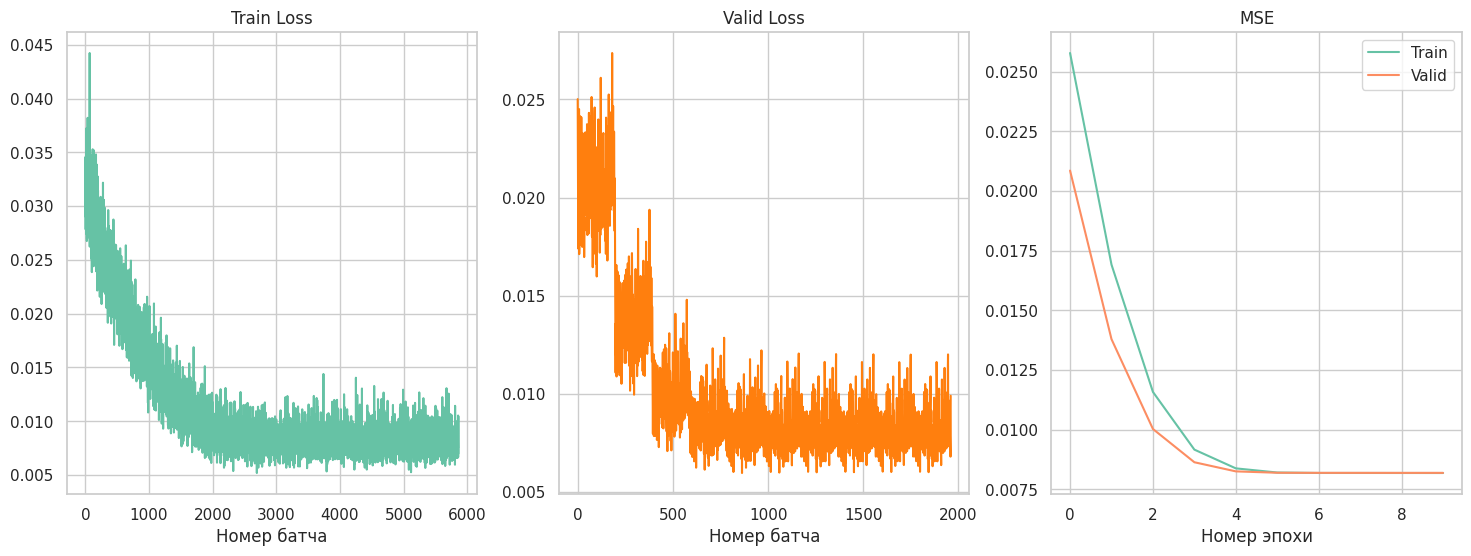

Номер эпохи: 10 | Время обучения эпохи: 0m 36s


In [ ]:
# Обучение стандартной модели
training_loop(std_model, std_optimizer, 10)

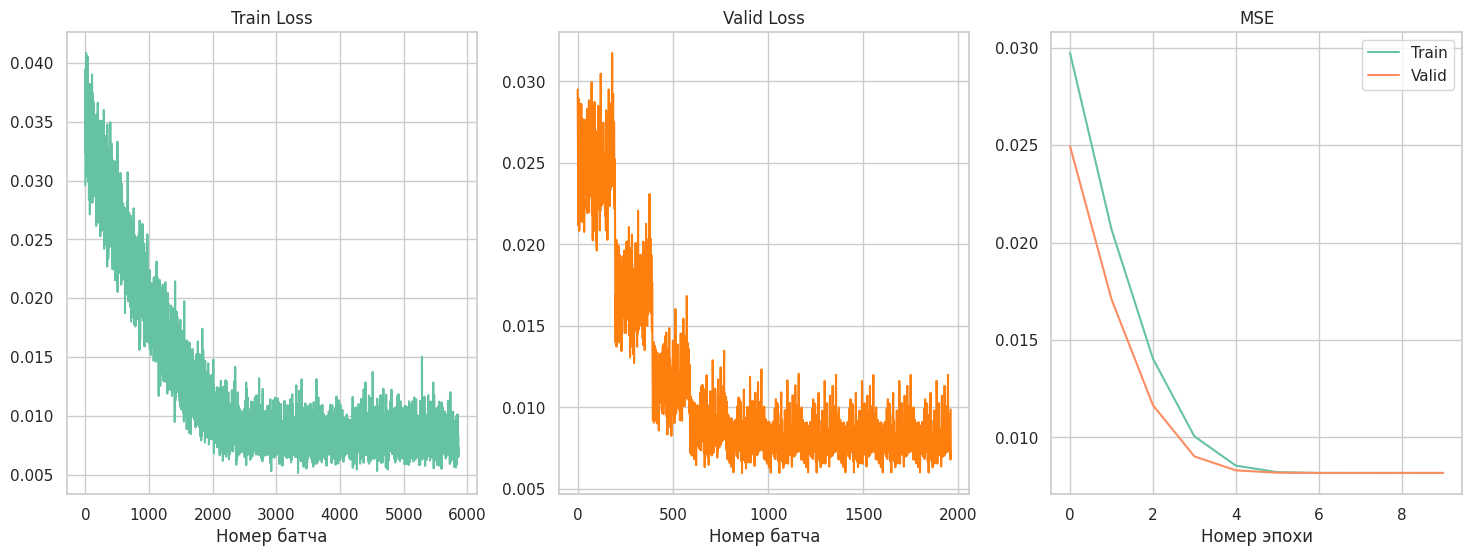

Номер эпохи: 10 | Время обучения эпохи: 0m 34s


In [ ]:
# Обучение модели с другим параметром эмбединга
training_loop(emb_model, emb_optimizer, 10)

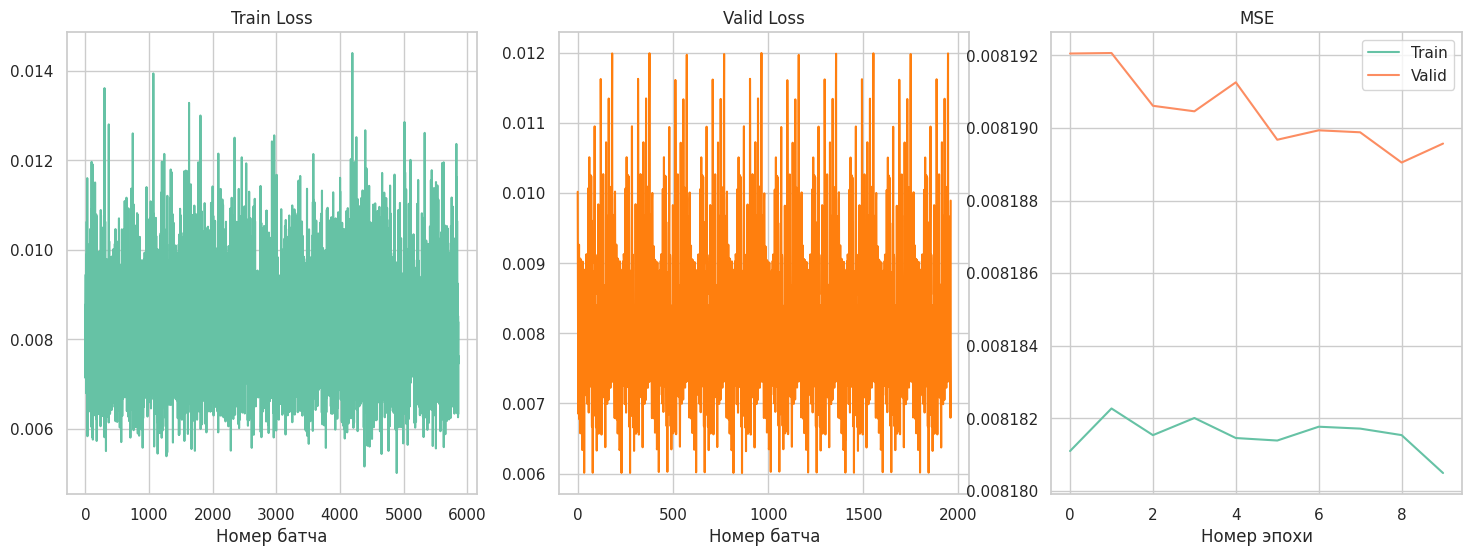

Номер эпохи: 10 | Время обучения эпохи: 0m 26s


In [ ]:
# Обучение модели с другой размерностью скрытого состояния
training_loop(rnn_model, rnn_optimizer, 10)

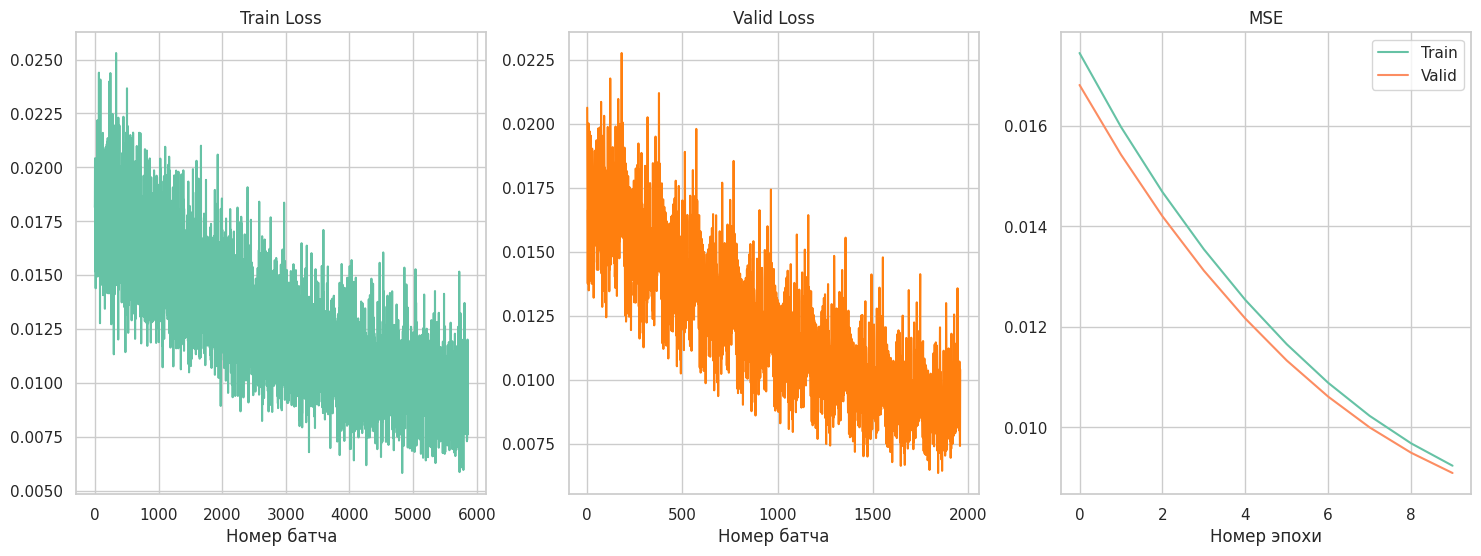

Номер эпохи: 10 | Время обучения эпохи: 0m 37s


In [ ]:
# Обучение модели с другим шагом обучения
training_loop(stp_model, stp_optimizer, 10)

Сделаем некоторый вывод по нарисованным графикам:

1) все модели достигли точности по mse примерно < 0.01

2) все модели, кроме rnn_model, имеют график mse в виде убывающей ветви гиперболы

3) Модели std_model и emb_model практически не отличаются, поэтому можно сделать вывод, что изменение гиперпараметра emb_size на малых величинах (25-50) слабо влияет на результат обучения

4) изменение шага оптимизации просто растянуло обучение модели stp_model на большее число эпох в отличие от std_model и emb_model

5) наиболее странной является модель rnn_model, потому что она обучилась уже на первой эпохе и достигает оличныз результатов, но к сожалению сама модель выраждается в константу

Такое долгое обучение обязательно нужно сохранять, поэтому создадим отдельные файлы, содержащие коэффициенты моделей.

In [ ]:
models = [std_model, emb_model, rnn_model, stp_model]
models_names = ["std_model", "emb_model", "rnn_model", "stp_model"]

for idx in range(len(models)):
    torch.save(
        models[idx].state_dict(),
        f"{models_names[idx]}.pth",
    )

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

In [ ]:
data_batch, target_batch = next(iter(valid_loader))

# Применяем модель, получаем предсказания
with torch.no_grad():
    std_preds = std_model(data_batch.to(device)).squeeze()
    emb_preds = emb_model(data_batch.to(device)).squeeze()
    rnn_preds = rnn_model(data_batch.to(device)).squeeze()
    stp_preds = stp_model(data_batch.to(device)).squeeze()

In [ ]:
# Вернем значения предсказаний к исзодным числам

std_preds = scaler.inverse_transform(std_preds.cpu().numpy().reshape(-1, 1))
emb_preds = scaler.inverse_transform(emb_preds.cpu().numpy().reshape(-1, 1))
rnn_preds = scaler.inverse_transform(rnn_preds.cpu().numpy().reshape(-1, 1))
stp_preds = scaler.inverse_transform(stp_preds.cpu().numpy().reshape(-1, 1))

# Вернем изначальные значения таргета
target_batch = scaler.inverse_transform(target_batch)

Приведем пару примеров работы разных моделей на примерах из валидационной выборки.

In [ ]:
# Выведем предсказания для 2 случайных примера из тестового батча
indices = torch.randint(low=0, high=len(data_batch), size=(2,))
for idx in indices:
    print("=" * 20)
    print("Text:")
    text = " ".join(
        [
            token
            for token in vocab.lookup_tokens(data_batch[idx].tolist())
            if token not in ["<unk>", "<pad>"]
        ]
    )
    print(text)
    print(f"True salary: {target_batch[idx].item()}")
    print(f"Result of std_model: {int(std_preds[idx].item())}")
    print(f"Result of emb_model: {int(emb_preds[idx].item())}")
    print(f"Result of rnn_model: {int(rnn_preds[idx].item())}")
    print(f"Result of stp_model: {int(stp_preds[idx].item())}")
    print()

Text:
My client urgent requirement MI Technical Analyst advanced skills Business Objects Data Services ETL The role initially 4 month contract possible extensions based centre Bristol great access Bristol Temple train station The Role To support develop financial reporting solutions use finance department The Finance Systems Finance Reporting teams support wide number technical functions within finance department The main products used Elite financial system Business Objects SQL along Excel VBA Models Job Expectations Support maintenance Firms financial reporting models Business Objects Business Object Planning Business Planning Consolidation SQL Excel Models Interpret requests information formulate developments required reporting solutions Second line support data integrity issues within reporting models Assist implementation changes identified system impact analysis report specifications Understand firm data business rules processes implications reporting databases Technical Experien

In [ ]:
def MSE(pred, target):
    return np.mean((pred - target) ** 2)

In [ ]:
print(f"MSE of std_model: {MSE(std_preds, target)}")
print(f"MSE of emb_model: {MSE(emb_preds, target)}")
print(f"MSE of rnn_model: {MSE(rnn_preds, target)}")
print(f"MSE of stp_model: {MSE(stp_preds, target)}")

MSE of std_model: 311016182.37695175
MSE of emb_model: 310909932.706865
MSE of rnn_model: 310898965.72984827
MSE of stp_model: 344063462.0239769


**Вывод:** В ходе работы над задачей мы построили несколько моделей, отличающихся друг от друга некоторыми гиперпараметрами. Все модели достигли довольно зорошей точности по метрике mse (на нормализованных данных), но к сожалению некоторые вырадились в константу.
Также нашли некоторые возможные зависимости модели от ее гиперпараметров:

emb_size: не показало изменения

rnn_num_units: уменьшение параметра повысило точноть и скорость обучения, но модель вырадилась в константу

lr (шаг оптимизации): уменьшение параметра растянуло процесс обучения

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [3]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers
import bitsandbytes as bnb

assert torch.cuda.is_available(), "для этой части понадобится GPU"

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [4]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Хотим написаать prompt, чтобы модель предсказывала размер заработной платы по приведенному тексту, а для этого воспользуемся методом Few-Shot Learning, то есть приведем несколь примеров того, как модель должна работать с последующими данными, также специально для этого будем использовать разграничивающие символы:

для отделения примеров - ###

для ожидаемого ответа от модели - >>>

In [5]:
prompt = """
A leading global wealth manager seeking HR Business Partner provide excellent front line HR generalist support across complex global business unit The role involve individual working closely collaboratively various business leads establish execute people agenda line business corporate HR strategies The role responsibilities include   Providing active advisory role partnership business leadership teams HR issues reward resource planning employee relations talent performance organisation development etc   Leading design alignment HR policy support business strategy across wider platform   Providing support key business transformation programmes inception implementation   Coaching supporting challenging senior business leaders aspects people agenda   Taking accountability partnering business leaders maintaining monitoring Group Standard People Risk within business area The successful candidate must financial services experience proven track record business partnering within commercial environment In addition experience implementing transformation strategy whilst fulfilling operational advisory role key position The team looking someone focus continuous improvement able deliver quality results positive influential style This role fantastic opportunity incumbent involved variety change transformation projects opportunity demonstrate creativity pragmatism If would like apply role HR Business Partner find please apply online
>>> 78000

Marketing Database Customer Insight Manager   Essex Hertfordshire commutable North London A successful retail business based Harlow looking experienced Marketing Data Manager newly created role within marketing department This role take responsibility effectively collecting recording analysing data marketing campaigns maintaining developing databases strategy well effectively communicating performance marketing department whole effective changes made support company growth To suitable role must following   Previous experience analysing marketing data provide insight advice future campaigns   Proven experience contributing marketing strategy campaigns   Database management experience   Advanced Microsoft Excel skills Any experience using methods within retail sector would seen advantageous although essential This role paying salary To apply Marketing Data Manager role please send copy CV quoting reference number The Ashdown Group Ltd acts employment agency respect permanent vacancies employment business respect temporary vacancies
>>> 40000

Project Management Support Officer Belfast 3 months /day Our client embarked Transformation Project ensure operations transport branch service driven customer focused along providing consistent high quality service values money This role provide support Programme Manager delivery phase number projects The primary role compile update overall programme plans escalate planning issues well maintaining project files You also responsible document control process progress organise minute Project Board meetings administering process risks issues changes well general support project manager Due nature urgency post candidates holding held high level security clearance past welcome apply Please note successful applicants required security cleared prior appointment take minimum 10 weeks LA International Computer Consultants Ltd HMG Approved Consultancy operates IT Engineering Consultancy Employment Business Agency depending upon precise nature work security cleared jobs non clearance vacancies welcome applications sections community people diverse experience backgrounds Award Winning LA International Computer Consultants Ltd Recruiter Awards Excellence   Best IT Best Public Sector Gold Awards This job originally posted
>>> 42000

My client urgent requirement MI Technical Analyst advanced skills Business Objects Data Services ETL The role initially 4 month contract possible extensions based centre Bristol great access Bristol Temple train station The Role To support develop financial reporting solutions use finance department The Finance Systems Finance Reporting teams support wide number technical functions within finance department The main products used Elite financial system Business Objects SQL along Excel VBA Models Job Expectations Support maintenance Firms financial reporting models Business Objects Business Object Planning Business Planning Consolidation SQL Excel Models Interpret requests information formulate developments required reporting solutions Second line support data integrity issues within reporting models Assist implementation changes identified system impact analysis report specifications Understand firm data business rules processes implications reporting databases Technical Experience Needed Business Objects including support development maintenance ETL universe Reports Developing supporting MS Excel including Visual Basic Experience IT business analysis Experience undertaking change management role throughout project lifecycle Proven record developing reporting applications report writing skills Good relational database skills Please contact directly send CV immediately critical role company help provide services end client Interview scheduled early next week start soon possible right candidate Hays Specialist Recruitment Limited acts employment agency permanent recruitment employment business supply temporary workers By applying job accept T C Privacy Policy Disclaimers found hays.co.uk
>>> 81249

We fantastic opportunity temp perm basis supply chain analyst immediate start providing key analytical support Supply Chain department leading retailer You responsible maintenance reporting development growing number Microsoft access based applications using Excel writing SQL statements manipulate data You must previous experience constructing evaluating reports working project based initiatives providing data assist decision making within Supply Chain function If   Commercial awareness retail environment   Strong analytical experience ability manage analytical projects completion Advanced Access Excel skills knowledge SQL   Experience manipulating data produce informative reports also ability effectively communicate information order influence business decisions This operational role highly analytical role would suit Business Data Analyst someone Financial Analyst background would like specialise Supply Chain Our client offering competitive package return This job originally posted
>>> 36000

Corporate Traveller 's Business Travel Consultants among highest earners industry Our continued success led impressive growth means 're nation ambitious individuals join team Business Travel Consultants Currently brand new Business Travel Consultant opportunities Woking Why Join Our Business Travel Consultant Team Corporate Traveller 's company culture simply energy We 're exceptionally proud service shows As part global Flight Centre Group also offer Business Travel Consultants awardwinning benefits including Uncapped commission structure business ownership schemeDiscounted travel fantastic incentives world 's top travel providersIndustry renowned social events excellent company cultureExceptional career progression worldwide opportunitiesFasttrack leadership programme develop future leadersComprehensive induction sales product leadership trainingFree confidential financial advice inhouse financial advisorsFree health consultations discounted fitness sessions gym membershipsDiscounted physiotherapy massage reflexology taxfree bikes … Opportunityto take three month sabbatical five years These benefits make us stand travel companies also placed us The Sunday Times Best Companies Work For eight years Business Travel Consultant Responsibilities Drawing upon communication skills love things travel Business Travel Consultants build manage portfolio corporate clients spend 2M. This client portfolio essentially becomes personal profitable business From booking flights accommodation arranging visas travel insurance ensure clients travel plans run without Business Travel Consultant Requirements Corporate Traveller renowned fantastic team culture extraordinary level customer care As ’re looking enthusiastic individuals ability build lasting relationships clients Specifically need A minimum one years experience travel appetite sales sell people skills impressive client handling key accounts Finally ambition tenacious streak also essential ingredient Corporate Traveller realm career opportunities available UK overseas As company continues grow want career grow us
>>>
"""

Правильный ответ 27000, теперь можно посмотреть, что же ответит модель.

In [6]:
batch = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to(
    device
)

output_tokens = model.generate(
    **batch, max_new_tokens=10, do_sample=True, temperature=0.8
)

print("Input batch (encoded):", batch)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Input batch (encoded): {'input_ids': tensor([[    1, 29871,    13,  ...,  6778, 29958,    13]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')}

Output: <s>
A leading global wealth manager seeking HR Business Partner provide excellent front line HR generalist support across complex global business unit The role involve individual working closely collaboratively various business leads establish execute people agenda line business corporate HR strategies The role responsibilities include   Providing active advisory role partnership business leadership teams HR issues reward resource planning employee relations talent performance organisation development etc   Leading design alignment HR policy support business strategy across wider platform   Providing support key business transformation programmes inception implementation   Coaching supporting challenging senior business leaders aspects people agenda   Taking accountability partnering business le

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:** Такая модель довольно не точна, так как количество примеров, по которым модель может предсказать размер заработной платы мало, поэтому трудно добиться результатов близких к модели, обученной специально под эту цель. Поэтому, если есть возможность использовать модель, которая специально была обучена под конкретную цель, то лучше использовать ее, чем хорошую модель, которая нацелена на решение большего спектра задач.
(двух дней не хватило подобрать, чтобы подобрать хорошие данные и ресурсы google collab закончились, надеюсь можно будет исправить эти пункты на дорешке)

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*